# 1. [30] If there's no asparagus in Innopolis...

When you find something that you like - whether it is a poem, song, or image, it's often useful to have an option to find similar items, such that you can enjoy songs of the same kind, for example. For this there exist **recommender systems**, and we will build one today. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have good asparagus in Innopolis?

The recommender system will be based on the vector-space model + dimensionality reduction + cosine similarity measure.

In [20]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm

## 1.1. Reading the dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/IUCVLab/information-retrieval/blob/main/datasets/nutrition.csv

In [5]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
dimensions = dataset.columns[1:]

print("Names:", *names[:5], "...", sep=" | ")
print()
print("Classes:", *set(classes_list), sep=" | ")
print()
print("Dimensions:", *dimensions[:5], "...", sep=" | ")

dataset.head()

Names: | Asparagus, 5 spears (93 g/3.3 oz) | Bell Pepper, 1 medium (148 g/5.3 oz) | Broccoli, 1 medium stalk (148 g/5.3 oz) | Carrot, 1 carrot, 7" long, 1 1/4" diameter (78 g/2.8 oz) | Cauliflower, 1/6 medium head (99 g/3.5 oz) | ...

Classes: | Fruits Serving Size (gram weight/ounce weight) | Seafood, Serving Size (84 g/3 oz) | Vegetables, Serving Size (gram weight/ ounce weight)

Dimensions: | Calories | Calories from Fat | Total Fat 1 | Total Fat 2 | Sodium 1 | ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## 1.2. Assigning colors each food item
Building a `color_list` which attributes a color to each item.

In [6]:
classes = list(set(classes_list))
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
print(class_colors)
color_list = [class_colors[a] for a in classes_list]

{'Fruits Serving Size (gram weight/ounce weight)': 'red', 'Seafood, Serving Size (84 g/3 oz)': 'green', 'Vegetables, Serving Size (gram weight/ ounce weight)': 'blue'}


## 1.3. Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [7]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X, Y, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
    
def show_points_3d(X, Y, Z):
    global color_list
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## 1.4. Data Visualization
Matrix `A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 features). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw values, columns are objects (61, 22)


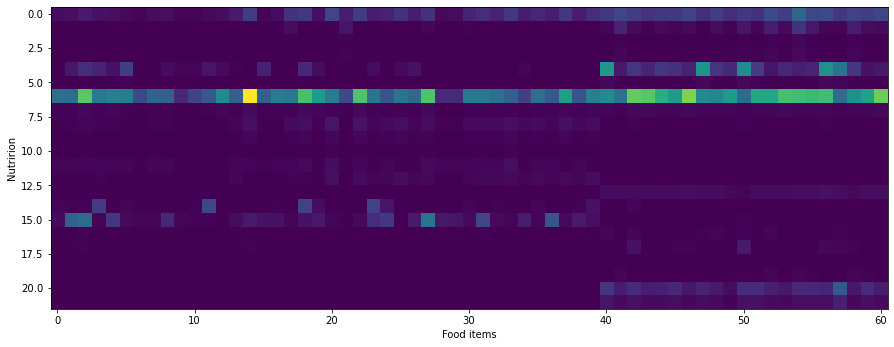

2 random dimensions distribution


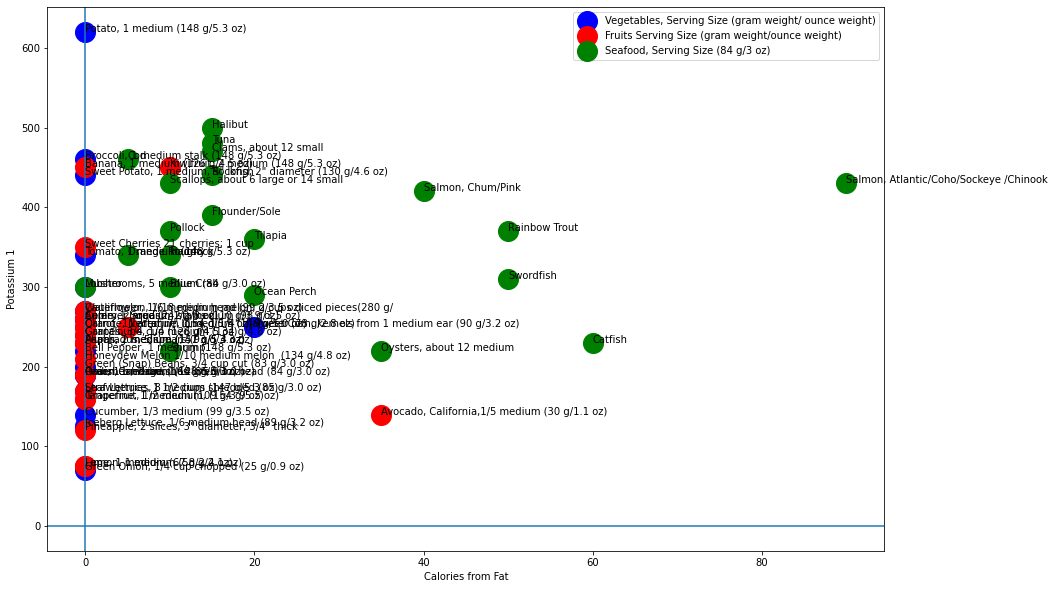

In [8]:
A = np.array(dataset.values[1:,1:-1].astype(float))
print("Raw values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutririon")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## 1.5. [10] Dimensionality reduction with Principal Components Analysis
Principal components are the dimensions, which express dataset diversity in the best way: the variance is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's keep 3 principal components. **Fill in the code to apply PCA to our data**.

In [10]:
from sklearn.decomposition import PCA
k = 3
pca = PCA(n_components=3)
#TODO apply PCA to matrix A, and save the results to Ak
Ak = pca.fit_transform(A)
Ak.shape

(61, 3)

Check how much variance is explained by the first `k` components. Refer to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [11]:
#TODO print ratios of variance explained by the first k components
print(pca.explained_variance_ratio_)

[0.56816006 0.24450404 0.09653148]


Now, let's **visualize** the data after transformation applied.

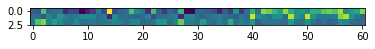

2 first dimensions


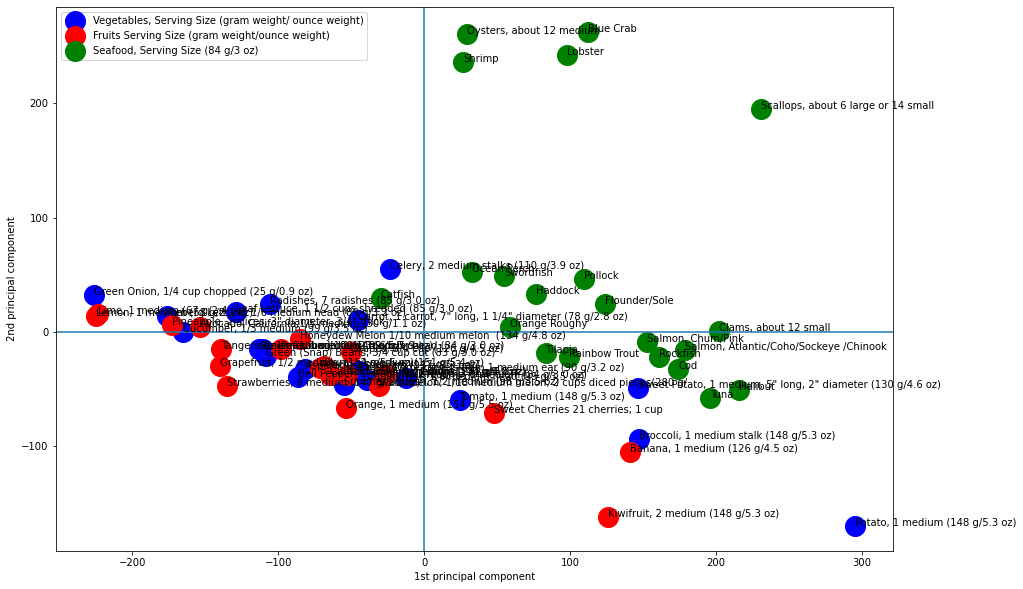

3 first dimensions


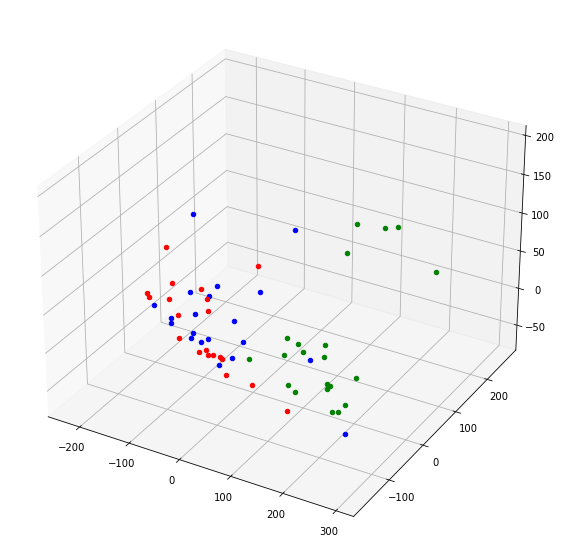

In [12]:
plt.imshow(Ak.T)
plt.show()

print("2 first dimensions")
show_points_2d(Ak.T[0], Ak.T[1], "1st principal component", "2nd principal component")
print("3 first dimensions")
show_points_3d(Ak.T[0], Ak.T[1], Ak.T[2])

## 1.6. [10] Norming
It can happen, that some food is more "watered" than the others. See, how different are celery and popatos in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ distance to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same" even if nutrition is of different scale. Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

2 first dimensions


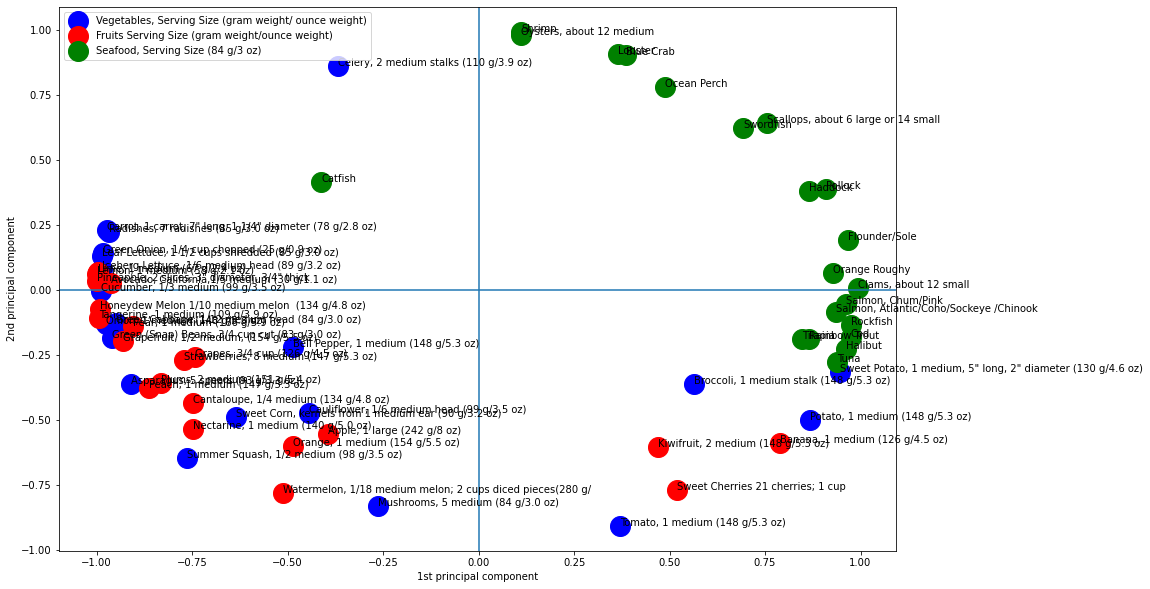

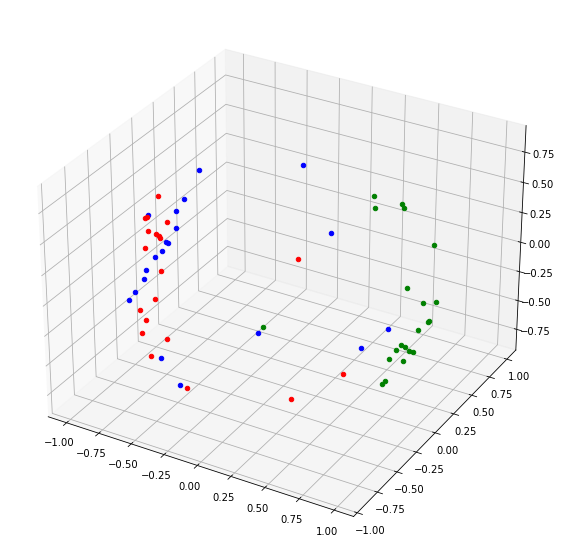

In [25]:
def norm_vectors(A):
    An = A.copy()
    #TODO write here a code that will norm each vector, 
    # i.e. will divide each row of A by its L2 norm ||A[i]||
    norms = norm(An, axis=1, ord=2)
    norms = norms.reshape(An.shape[0], 1)
    return An / norms
    
An = norm_vectors(Ak)

print("2 first dimensions")
show_points_2d(An.T[0], An.T[1], "1st principal component", "2nd principal component")
show_points_3d(An.T[0], An.T[1], An.T[2])

## 1.7. [10] Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend closest food items in terms of nutrition. 

**Please, write the code that will return $k$ closest food items to the provided query vector.**

In [133]:
def find_k_closest(query, dataset, k=5):    
    #TODO write here the code that will find 5 closest rows in dataset in terms of cosine similarity
    #HINT: as vectors in dataset are already normed, cosine similarity is just a dot product.
    
    cosine_sim = dataset.dot(query)
    top_k_ind = np.flip(np.argsort(cosine_sim)[-k:])
    vectors = np.take(dataset, top_k_ind, axis=0)
    return list(zip(top_k_ind, vectors, cosine_sim[top_k_ind]))


recommend_to = 0
r = find_k_closest(An[recommend_to,:], An)


print("For:", names[recommend_to])
for k, v, p in r:
    if recommend_to != k: # exclude itself 
        print("\t", names[k], "sim =", p)

For: Asparagus, 5 spears (93 g/3.3 oz)
	 Peach, 1 medium (147 g/5.3 oz) sim = 0.9900306633803703
	 Green (Snap) Beans, 3/4 cup cut (83 g/3.0 oz) sim = 0.983096080859485
	 Plums, 2 medium (151 g/5.4 oz) sim = 0.9740244451806316
	 Onion, 1 medium (148 g/5.3 oz) sim = 0.9705752498785493


## 1.8. (Extra task) Try this on text data

Now, it's time to check how well does this work for text data. 
1. Load the inverted index you built [at the last lab](2021S-0506%20Index%20and%20Spellchecking.ipynb) with other files needed for the task; 
2. Using these files, build Document-Term Matrix (DTM), where each row is a document, and each column is a term, and at the intersection there's a TF-IDF value;
3. Apply the same procedure as above: **PCA transform + normalization**. Choose the number of dimensions to preserve at least 90\% of variance.
4. Apply similar procedure: **SVD transform + normalization**. Use the same number of dimensions.
5. For a given article (print its url) show urls of 5 closest articles using cosine similarity. Are results different for 3 and 4?
6. Similarly, show urls of closest articles to a short query, such as "last grammy award".

Display cosine similarity for all search results along with urls.

In [134]:
# Place for your code here

# 2. [70] Evolving vector-space model
This lab will be devoted to the use of `doc2vec`/... model for the needs of information retrieval and text classification.  

## 2.1. [40] Searching in the curious facts database
The facts dataset is given [here](https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt), take a look.  We want you to retrieve facts **relevant to the query** (whatever it means), for example, you type "good mood", and get to know that Cherophobia is the fear of fun. For this, the idea is to utilize document vectors. However, instead of forming vectors with tf-idf and reducing dimensions, this time we want to obtain fixed-size vectors for documents using `doc2vec` ML model.

### 2.1.1. Loading trained `doc2vec` model

First, let's load the pre-trained `doc2vec` model from https://github.com/jhlau/doc2vec (Associated Press News DBOW (0.6GB)), and install dependency.

Unpack a model into 3 files and target the main one in your code:
```
doc2vec.bin  <---------- this
doc2vec.bin.syn0.npy
doc2vec.bin.sin1neg.npy
```

In [84]:
!pip install gensim

     |████████████████████████████████| 24.2 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 11.3 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.2.0-py3-none-any.whl size=109632 sha256=a140d6906a9e90a1e7f73f484caa7ff55155213e63d99c9bc2a8030592ce5df5
  Stored in directory: /Users/osmiyg/Library/Caches/pip/wheels/24/f6/ea/70a0761bdfaeacff66662751fe71920e25c4c43d97098a3886
Successfully built smart-open


In [179]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
model = Doc2Vec.load('doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))

<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>


### 2.1.2. [10] Reading data

Now, let's read the facts dataset. Download it from the abovementioned url and read to the list of sentences.

In [180]:
from urllib.request import urlopen

#TODO read facts into a list of facts
url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt"
link = urlopen(url)
text = link.read().decode("utf-8")

facts = text.split("\n")

### 2.1.3. Tests

In [181]:
print(*facts[:5], sep='\n')

assert len(facts) == 159
assert ('our lovely little planet') in facts[0]

1. If you somehow found a way to extract all of the gold from the bubbling core of our lovely little planet, you would be able to cover all of the land in a layer of gold up to your knees.
2. McDonalds calls frequent buyers of their food "heavy users."
3. The average person spends 6 months of their lifetime waiting on a red light to turn green.
4. The largest recorded snowflake was in Keogh, MT during year 1887, and was 15 inches wide.
5. You burn more calories sleeping than you do watching television.


### 2.1.4. [10] Transforming sentences to vectors

Transform the list of facts to `numpy.array` of vectors corresponding to each document (`sent_vecs`), inferring them from the model we just loaded.

In [182]:
#TODO infer vectors
sent_vecs = np.array([model.infer_vector(sent.split()) for sent in facts])

### 2.1.5. Tests 

In [183]:
print(sent_vecs.shape)
assert sent_vecs.shape == (159, 300)

(159, 300)


### 2.1.6. [10] Find closest

Now find 5 facts which are closest to the query using cosine similarity measure.

In [184]:
#TODO output closest facts to the query
query = "good mood"

vector_query = model.infer_vector(query.split())
query_norm = np.linalg.norm(vector_query)

r = find_k_closest(vector_query/query_norm, norm_vectors(sent_vecs))

print("Results for query:", query)
for k, v, p in r:
    print("\t", facts[k], "sim=", p)

Results for query: good mood
	 144. Dolphins sleep with one eye open! sim= 0.6466501
	 44. Honey never spoils. sim= 0.6011547
	 97. 111,111,111 X 111,111,111 = 12,345,678,987,654,321 sim= 0.58091015
	 92. Just like fingerprints, everyone has different tongue prints. sim= 0.5761469
	 118. An ostrich's eye is bigger than its brain sim= 0.57506895


### 2.1.7. [10] Measure pFound@5 and mAP@5 for the following query bucket:
```
good mood
gorilla
woman
earth
japan
people
math
```

In [217]:
import math 

def pFound(search_results, relevance, pBreak=0.15, pRel=0.4):
    # TODO: calculate pFound score for search results, treating relevance judgments as binary - either relevant or not
    
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    
    pFound_list = []
    for query_id, search_list in enumerate(search_results):
        relevant_docs = set([x[0] for x in relevance[query_id + 1]])
        
        pLook_list = []
        pRel_list = []
        pFound = 0
        for i, doc_id in enumerate(search_list):
            pLook_list.append(pLook_list[-1]*(1 - pBreak)*(1 - pRel_list[-1]) if pLook_list else 1)
            
            pRel_list.append(pRel if doc_id in relevant_docs else 0)
            
            pFound += pLook_list[i] * pRel_list[i]
        pFound_list.append(pFound)
        
    return mean(pFound_list)

In [219]:
from statistics import mean

def mean_avg_precision(search_results, relevance):
    # TODO: calculate MAP score for search results, treating relevance judgments as binary - either relevant or not.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    average_precision = []
    for i, documents in enumerate(search_results):
        relevant_results = set([x[0] for x in relevance[i + 1]])
        prec = []
        relevant_docs = 0
        for j, doc in enumerate(documents):
            if doc in relevant_results:
                relevant_docs += 1
                prec += [relevant_docs / (j + 1)]
        average_precision += [mean(prec) if len(prec) > 0 else 0]
    return mean(average_precision)

In [221]:
# write your code here

# It is not possible to calculate MAP and PFound withoud given relevance for this queries :)

## 2.2. [30] Training doc2vec model and documents classifier

Now you will to train doc2vec model yourself based on [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads). It is also cloned in your repository: [just unpack](https://github.com/IUCVLab/information-retrieval/blob/main/datasets/topic-modelling.zip).

### 2.2.1. [10] Read dataset

First, read the dataset - it consists of 4 parts, you need to merge them into single list. 

In [186]:
import os
#TODO read the dataset into list
path = "../datasets/topic-modelling/"
_, _, filenames = next(os.walk(path))

all_data = []
for label, filename in enumerate(filenames):
    with open(path + filename, "r") as f:
        sentences = f.read().split("\n")
        all_data.extend([(sentence.split(), label) for sentence in sentences])


### 2.2.2. Test reading

In [187]:
print(len(all_data))
assert len(all_data) == 15002

15006


AssertionError: 

## 2.3. Training your own `doc2vec` model

Train a `doc2vec` model based on the dataset you've loaded. The oversimplified example of training is provided.

### 2.3.1. Training example

In [168]:
#TODO change this according to the task
# small set of tokenized sentences
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# just a test set of tokenized sentences
print(common_texts, "\n")
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
print(documents, "\n")
# train a model
model = Doc2Vec(
    documents,     # collection of texts
    vector_size=5, # output vector size
    window=2,      # maximum distance between the target word and its neighboring word
    min_count=1,   # minimal number of 
    workers=4      # in parallel
)

# clean training data
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# save and load
model.save("d2v.model")
model = Doc2Vec.load("d2v.model")

vec = model.infer_vector(["system", "response"])
print(vec)

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']] 

[TaggedDocument(words=['human', 'interface', 'computer'], tags=[0]), TaggedDocument(words=['survey', 'user', 'computer', 'system', 'response', 'time'], tags=[1]), TaggedDocument(words=['eps', 'user', 'interface', 'system'], tags=[2]), TaggedDocument(words=['system', 'human', 'system', 'eps'], tags=[3]), TaggedDocument(words=['user', 'response', 'time'], tags=[4]), TaggedDocument(words=['trees'], tags=[5]), TaggedDocument(words=['graph', 'trees'], tags=[6]), TaggedDocument(words=['graph', 'minors', 'trees'], tags=[7]), TaggedDocument(words=['graph', 'minors', 'survey'], tags=[8])] 

[ 0.07033173 -0.05021107  0.08924578  0.01414358  0.07432501]


### 2.3.2. [10] Form train and test datasets

Transform documents to vectors and split data to train and test sets. Make sure that the split is stratified as the classes are imbalanced.

In [177]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_data)]

model = Doc2Vec(
    documents,     # collection of texts
    vector_size=5, # output vector size
    window=2,      # maximum distance between the target word and its neighboring word
    min_count=1,   # minimal number of 
    workers=4      # in parallel
)

model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# save and load
model.save("d2v.model")

In [191]:
model = Doc2Vec.load("d2v.model")

doc_vecs = np.array([model.infer_vector(doc[0]) for doc in all_data])
labels = np.array([doc[1] for doc in all_data])

In [199]:
print(doc_vecs.shape)

(15006, 5)


In [209]:
#TODO transform and make a train-test split
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, random_state=42)
for train_index, test_index in sss.split(doc_vecs, labels):
    X_train, X_test = doc_vecs[train_index], doc_vecs[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

1501


### 2.3.3. [10] Train topics classifier

Train a classifier that would classify any document to one of four categories: fuel, brain injury, music, and economy.
Print a classification report for test data.

In [212]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train SVM
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [215]:
y_pred = clf.predict(X_test)

In [216]:
#TODO train a classifier and measure its performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       0.76      0.75      0.76       209
           2       0.70      0.08      0.15        85
           3       0.61      0.84      0.71       207

    accuracy                           0.89      1501
   macro avg       0.77      0.67      0.65      1501
weighted avg       0.90      0.89      0.88      1501



Which class is the hardest one to recognize?

`The recall for class 2 is very small, thus class 2 is hard to classify`

### 2.4. Bonus task

What if we trained our `doc2vec` model using window size = 5 or 10? Would it improve the classification acccuracy? What about vector dimensionality? Does it mean that increasing it we will achieve better performance in terms of classification?

Explore the influence of these parameters on classification performance, visualizing it as a graph (e.g. window size vs f1-score, vector dim vs f1-score).